# Chapter 3b: Decision trees & tree ensembles

Decision trees, but more specifically decision tree ensembles such as Random Forest, are a standard Machine Learning method, alongside SVMs and the neural networks we will later study. We will follow the same structure as the previous notebook. We will start with the basics of decision trees and then move to a simple geoscience application, this time on the tectonic classification of basalts from geochemistry.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn import datasets

## 1. Decision tree

### 1.1. Definition

A decision tree is an intuitive way to classify or label objects, by asking a series of questions designed to zero-in on the classification by binary splitting, like in the _Guess Who_ board game (is she tall? yes/no, does she wear glasses? yes/no, etc.). In this section, we will describe the concept of decision tree classification using the _Iris flower data set_ (Fisher, 1936) which has become a typical test case for many statistical classification techniques in machine learning.

_Iris flower data set_: "_This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day (See Duda & Hart, for example). The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other_" (UCI Machine Learning Repository).

**EXERCISE 1:** Load the Iris dataset which is directly available via `datasets.load_iris()`. Plot the classes as a function of sepal length on the $x$-axis and sepal width on the $y$-axis and use `cmap = 'Spectral'` so that we get consistent figures throughout the notebook. _Hint: You will notice that the dataset has the structure of a dictionary. Explore the various attributes to find what you need. Then access the attribute by using `DATA_NAME.ATTRIBUTE_NAME`._

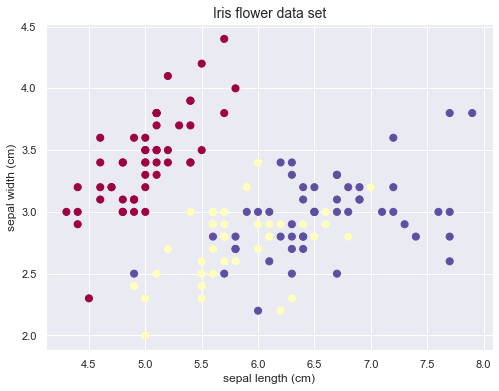

In [2]:
# YOUR CODE HERE


# SOLUTION
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features (sepal length in cm, sepal width in cm)
y = iris.target       # Iris Setosa, Iris Versicolour, Iris Virginica

plt.figure(figsize = (8,6))
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50, cmap = 'Spectral')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Iris flower data set', size = 14);

In [3]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

A decision tree, with depth 2, is displayed below to illustrate how the decisions are made to split between the 3 classes. We notice that each node in the tree splits the data into two groups using a cutoff value within one of the features. Notice that we define the model using `DecisionTreeClassifier` from `sklearn.tree`.

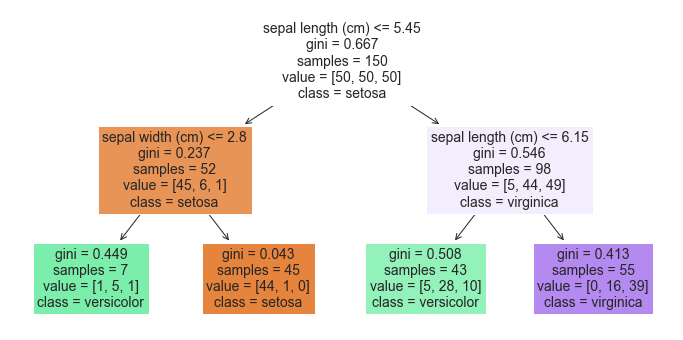

In [5]:
# DECISION TREE MODEL (to illustrate how decisions are made)
model_tree = DecisionTreeClassifier(max_depth = 2).fit(X, y)

# PLOT
plt.figure(figsize = (12,6))
plot_tree(model_tree, feature_names = iris.feature_names, class_names = iris.target_names, filled = True);

Let us have a look at the binary splitting process from depth 1 to depth 4. Note that the splitting is done such that each question (feature axis-aligned splits) will cut the number of options by approximately half. This is done by calculating an **homogeneity criterion**, as we will see in section 1.2 on hyperparameters.

In [6]:
def plot_boundaries(i, xlim, ylim):
    if i >= 0:
        if tree.feature[i] == 0:
            axi.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
            plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            axi.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
            plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])

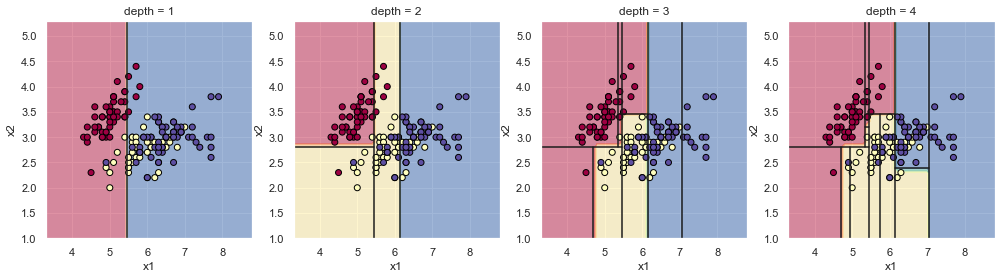

In [7]:
#create mesh
h = .1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

fig, ax = plt.subplots(1, 4, figsize=(17, 4))
for axi, depth in zip(ax, range(1, 5)):
    # MODEL (for different tree depths)
    model = DecisionTreeClassifier(max_depth = depth).fit(X, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # get binary splits
    tree = model.tree_

    # PLOT
    Z = Z.reshape(xx.shape)
    axi.contourf(xx, yy, Z, cmap = 'Spectral', alpha = .5)
    axi.scatter(X[:, 0], X[:, 1], c = y, cmap = 'Spectral', edgecolors='black')
    axi.set_xlabel('x1')
    axi.set_ylabel('x2')
    plot_boundaries(0, [x_min, x_max-h], [y_min, y_max-h])
    axi.set_title('depth = {0}'.format(depth))

**EXERCISE 2:** Explain what happens in a decision tree (how is the split done? what happens each time we increase the depth). Detail the answer by describing what you see on the plots above.

_YOUR ANSWER HERE_

SOLUTION

One split is done at each depth along one feature, hence the vertical or horizontal split lines on the plots. For each subset of data, a new split is done. Once a subset is homogeneous, no more split is done.

### 1.2. Hyperparameters

We just discovered the tree depth hyperparameter. Decision tree hyperparameters that may require tuning during model training are:
* Tree depth `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
* Homogeneity `criterion`: The function to measure the quality of a split. Supported criteria are `gini` for the Gini impurity and `entropy` for the information gain
* `min_samples_split`: The minimum number of samples required to split an internal node (`default=2`)
* `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches (`default=1`)
* For other hyperparameters, see [scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

**EXERCISE 3:** Run a decision tree classifier for each possible split criterion and plot the results (no need to use `plot_boundaries`). What do you notice?

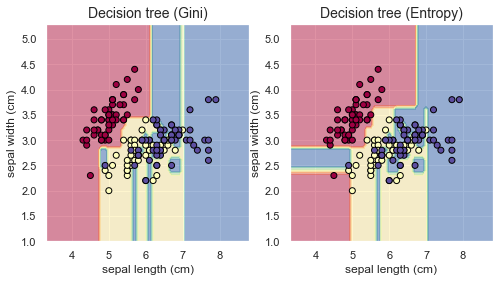

In [8]:
# YOUR CODE HERE



# SOLUTION
model_tree_gini = DecisionTreeClassifier(criterion = 'gini').fit(X, y)
model_tree_entr = DecisionTreeClassifier(criterion = 'entropy').fit(X, y)

Z_gini = model_tree_gini.predict(np.c_[xx.ravel(), yy.ravel()])   #.reshape(xx.shape)
Z_entr = model_tree_entr.predict(np.c_[xx.ravel(), yy.ravel()])   #.reshape(xx.shape)

Z_gini = Z_gini.reshape(xx.shape)
Z_entr = Z_entr.reshape(xx.shape)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].contourf(xx, yy, Z_gini, cmap = 'Spectral', alpha = .5)
axs[0].scatter(X[:, 0], X[:, 1], c = y, cmap = 'Spectral', edgecolors='black')
axs[0].set_xlabel(iris.feature_names[0])
axs[0].set_ylabel(iris.feature_names[1])
axs[0].set_title('Decision tree (Gini)', size=14)

axs[1].contourf(xx, yy, Z_entr, cmap = 'Spectral', alpha = .5)
axs[1].scatter(X[:, 0], X[:, 1], c = y, cmap = 'Spectral', edgecolors='black')
axs[1].set_xlabel(iris.feature_names[0])
axs[1].set_ylabel(iris.feature_names[1])
axs[1].set_title('Decision tree (Entropy)', size=14);

_YOUR ANSWER HERE_

SOLUTION

The 2 split criteria give similar results but not exactly the same.

Let's try to better understand how the Gini impurity metric works.

**EXERCISE 4:** Define the Gini function based on the following definition. Plot the Gini index for class 1 (corresponding to `p1`). What does the curve shape tells us?

Gini impurity is computed by summing probability $p_i$ of an item with label $i$ being chosen times the probability $\sum_{k \ne i} p_k = 1 - p_i$ of a mistake in categorizing that item.

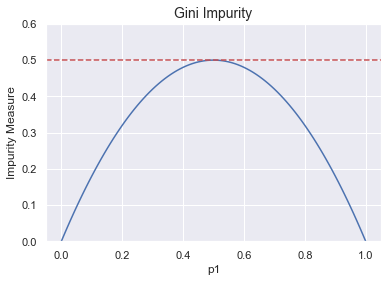

In [36]:
# YOUR CODE HERE
#def Gini(p1, p2):
#    Gini_val = ?
#    return(Gini_val)

#p1 = np.arange(0, 1.01, .01)
#p2 = p1[::-1]

#plt.plot...
#... multiple lines of code


# SOLUTION
def Gini(p1, p2):
    Gini_val = p1 * (1-p1) + p2 * (1-p2)
    return(Gini_val)

p1 = np.arange(0, 1.01, .01)
p2 = p1[::-1]

plt.plot(p1, Gini(p1, p2))
plt.axhline(y = .5, color='r', linestyle='--')
plt.xlabel('p1')
plt.ylabel('Impurity Measure')
plt.title('Gini Impurity', size = 14)
plt.ylim([0,.6]);

_YOUR ANSWER HERE_

SOLUTION
A Gini Impurity of 0 is the lowest and best possible impurity. It can only be achieved when everything is the same class (p=1). The shape is very similar to the entropy measure.

**EXERCISE 5:** Rewrite the previous code cell changing the Gini function to an entropy function to show that the 2 metrics are similar. Entropy is $I_E = - \sum_{i=1}^J p_i \log_2 p_i$.

<ipython-input-38-65569c1308a6>:6: RuntimeWarning: divide by zero encountered in log2
  entropy_val = - p1 * np.log2(p1) - p2 * np.log2(p2)
<ipython-input-38-65569c1308a6>:6: RuntimeWarning: invalid value encountered in multiply
  entropy_val = - p1 * np.log2(p1) - p2 * np.log2(p2)


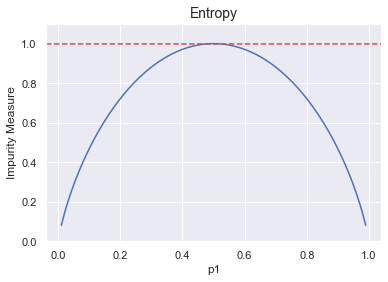

In [38]:
# YOUR CODE HERE


# SOLUTION
def Entropy(p1, p2):
    entropy_val = - p1 * np.log2(p1) - p2 * np.log2(p2)
    return(entropy_val)

p1 = np.arange(0, 1.01, .01)
p2 = p1[::-1]

plt.plot(p1, Entropy(p1, p2))
plt.axhline(y = 1, color='r', linestyle='--')
plt.xlabel('p1')
plt.ylabel('Impurity Measure')
plt.title('Entropy', size = 14)
plt.ylim([0,1.1]);

### 1.3. Pruning (against overfitting)

Notice from our previous results that we get very strangely shaped classification regions; there are for example some tall and thin areas and local patches of a class circled by another one. This is clear that this is less a result of the true, intrinsic data distribution, and more a result of a mix of the particular sampling used and noise properties of the data. it is very easy to go too deep in the tree (as done above), and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from (i.e. overfitting).

__EXERCISE 6:__ Prove that the decision tree classifier overfits the data. First use `train_test_split` and then compare model accuracy for training and test sets (using e.g. `accuracy_score(obs,pred)`).

In [31]:
# YOUR CODE HERE



# SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5)
model = DecisionTreeClassifier().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

Training accuracy: 0.9333333333333333
Test accuracy: 0.7066666666666667


__Pruning__ is one of the mainly used technique to reduce overfitting in decision trees. It reduces their size by removing sections of the tree that are non-critical and redundant to classify instances. Pruning reduces the complexity of the final classifier, and hence reduces overfitting. Two commonly used pruning types are:
1. _Pre-pruning_: Consists in stopping the growth of the decision tree on an early stage. For that we can limit the growth of trees by setting constrains on `max_depth`, `min_samples_split`, or `min_samples_leaf`.

An effective way is to grid search those parameters and choose the optimum values that gives the best performance on training data.

**EXERCISE 7:** Do a grid search for the following parameters: `max_depth` $=[2,4,6,8,10,12]$, `min_samples_split` $= [2,3,4]$ and `min_samples_leaf` $=[1,2]$. Calculate the accuracy of the pruned decision tree. Were those new results expectable? what are the best parameter values? _Hint: Copy-paste the grid search code from section 4.5 in chap2c notebook and modify accordingly._ 

In [46]:
# YOUR CODE HERE



# SOLUTION
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

model4gridsearch = DecisionTreeClassifier()
gcv = GridSearchCV(estimator = model4gridsearch, param_grid = params)
gcv.fit(X_train, y_train)

model_best = gcv.best_estimator_

model_best.fit(X_train, y_train)
y_train_pred = model_best.predict(X_train)
y_test_pred = model_best.predict(X_test)

print('Train score:', accuracy_score(y_train_pred, y_train))
print('Test score:', accuracy_score(y_test_pred, y_test))
gcv.best_params_

Train score: 0.7466666666666667
Test score: 0.7333333333333333


{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

_YOUR ANSWER HERE_

SOLUTION
You should see that the training accuracy is reduced compared to the exercise result but the test accuracy is now greater and closer to the training result.

We can now compare the original decision tree with the pre-pruned tree (you'll certainly observe different trees depending on the training set / test set split done above):

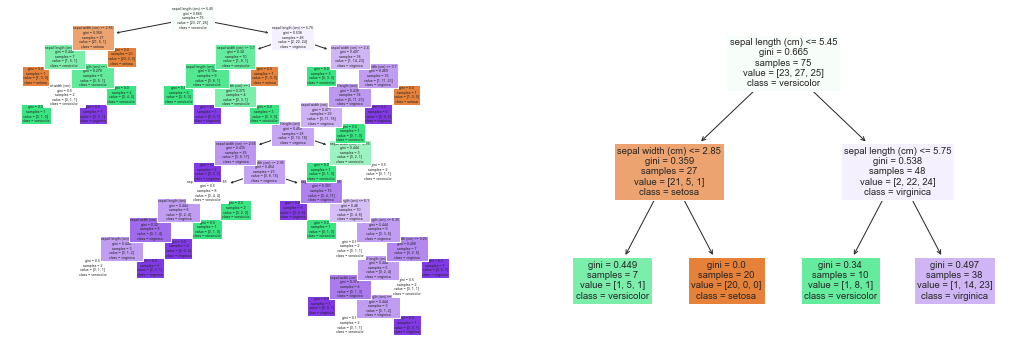

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
plot_tree(model, feature_names = iris.feature_names, class_names = iris.target_names, filled = True, ax = axs[0])
plot_tree(model_best, feature_names = iris.feature_names, class_names = iris.target_names, filled = True, ax = axs[1]);

2. _Postpruning_: Of the different techniques available, _cost complexity pruning_ is one of the most common. It is controlled by a new hyperparameter $\alpha$. As $\alpha$ increases, the number of nodes and depth decrease.

[0.         0.00055556 0.0025     0.00277778 0.00277778 0.0037037
 0.00416667 0.00444444 0.00444444 0.00462963 0.00470588 0.00515873
 0.00531798 0.00833333 0.00916667 0.01014051 0.01058824 0.01339963
 0.015      0.01849336 0.03747748 0.04872504 0.07846828 0.22910385]


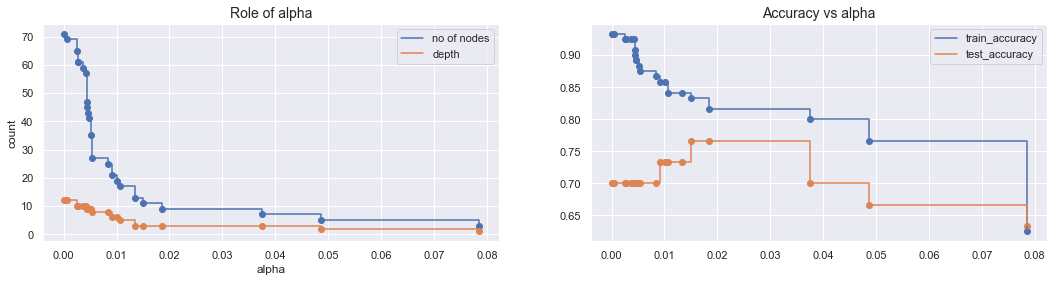

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

model = DecisionTreeClassifier()
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

# For each alpha, append model to list
models = []
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)

# remove trivial tree with only one node
models = models[:-1]
ccp_alphas = ccp_alphas[:-1]

# train for different alpha
train_acc = []
test_acc = []
for model in models:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred, y_train))
    test_acc.append(accuracy_score(y_test_pred, y_test))

node_counts = [model.tree_.node_count for model in models]
depth = [model.tree_.max_depth for model in models]

fig, axs = plt.subplots(1, 2, figsize=(18, 4))
axs[0].scatter(ccp_alphas, node_counts)
axs[0].scatter(ccp_alphas, depth)
axs[0].plot(ccp_alphas, node_counts, label = 'no of nodes', drawstyle = "steps-post")
axs[0].plot(ccp_alphas, depth, label = 'depth', drawstyle = "steps-post")
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('count')
axs[0].set_title('Role of alpha', size=14)
axs[0].legend()

axs[1].scatter(ccp_alphas,train_acc)
axs[1].scatter(ccp_alphas,test_acc)
axs[1].plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
axs[1].plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
axs[1].legend()
axs[1].set_title('Accuracy vs alpha', size=14);

**EXERCISE 8:** Describe the 2 plots. What is a good estimate of $\alpha$ in the present case? Once you have decided such value, run both a standard decision tree and a post-pruned model (using `DecisionTreeClassifier(ccp_alpha = YOUR_VALUE)`). Compare the 2 trees by plotting them.

_YOUR ANSWER HERE_



SOLUTION
We can see that for e.g. $\alpha = 0.01$, the model is not overfiting anymore and performance on test data has improved. As $\alpha$ increases, we see its role in reducing the model hyperparameters. When $\alpha$ becomes too high, information is lost with accuracy on both training set and test set decreasing.

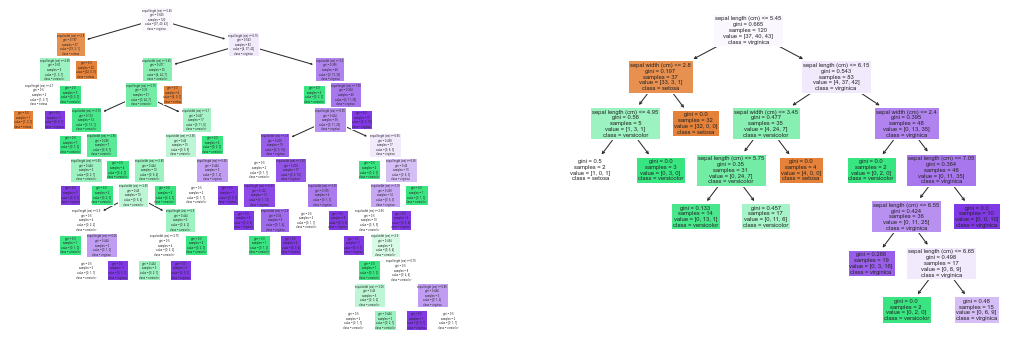

In [48]:
# YOUR CODE HERE
#model = ?
#model_postpruned = ?



#SOLUTION
model = DecisionTreeClassifier().fit(X_train, y_train)
model_postpruned = DecisionTreeClassifier(ccp_alpha = 0.01).fit(X_train, y_train)



# PLOT original decision tree versus post-pruned tree
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
plot_tree(model, feature_names = iris.feature_names, class_names = iris.target_names, filled = True, ax = axs[0])
plot_tree(model_postpruned, feature_names = iris.feature_names, class_names = iris.target_names, filled = True, ax = axs[1]);

## 2. Decision tree ensembles

Another way to see decision tree over-fitting is to look at models trained on random subsets of the data (as shown below). It is clear that in some places, the trees produce consistent results, while in other places, the trees give different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from all of these trees, we may obtain a better result. This is the basis of decision tree ensembling.

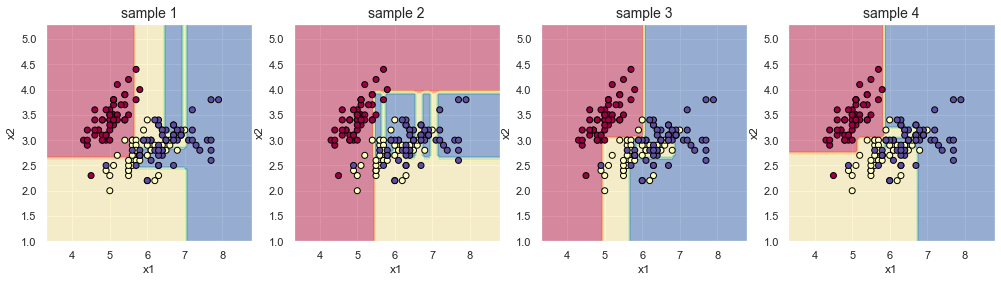

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(17, 4))
for axi, i in zip(ax, range(1, 5)):
    ind = np.random.choice(np.arange(len(y)), round(len(y)/4), replace=False)
    X_sample = X[ind]
    y_sample = y[ind]
    model_tree = DecisionTreeClassifier().fit(X_sample, y_sample)
    
    Z = model_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    axi.contourf(xx, yy, Z, cmap = 'Spectral', alpha = .5)
    axi.scatter(X[:, 0], X[:, 1], c = y, cmap = 'Spectral', edgecolors='black')
    axi.set_xlabel('x1')
    axi.set_ylabel('x2')
    axi.set_title('sample {0}'.format(i), size=14)

### 2.1. Bagging

An __ensemble method__ means that it relies on aggregating the results of an ensemble of simpler estimators (here `n_estimators` decision trees). The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting (Breiman, 1996).

**EXERCISE 9:** Apply bagging to decision trees by using `BaggingClassifier(WEAK_LEARNER, n_estimators = 100, max_samples = .8)`, the weak learner being a standard decision tree model. Then plot the result on top of the observations as done multiple times already.

Train score: 0.9333333333333333
Test score: 0.9


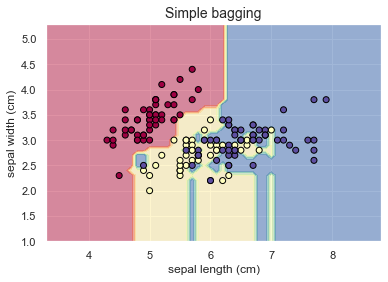

In [62]:
# YOUR CODE HERE



# SOLUTION
weak_learner = DecisionTreeClassifier()
model_bag = BaggingClassifier(weak_learner, n_estimators = 100, max_samples = .8)
model_bag.fit(X, y)

Z = model_bag.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = 'Spectral', alpha = .5)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = 'Spectral', edgecolors = 'black')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Simple bagging', size=14);

y_train_pred = model_bag.predict(X_train)
y_test_pred = model_bag.predict(X_test)
print('Train score:', accuracy_score(y_train_pred, y_train))
print('Test score:', accuracy_score(y_test_pred, y_test))

In the above example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.

### 2.2. Random Forest

__Random Forest__ (Ho, 1995; Breiman, 2001) improves on simple bagging by injecting randomness also deep inside the tree construction procedure by sub-sampling the list of features that are candidate for splitting: a new random set of features is considered at each new split. This randomness is controlled via the `max_features` parameter of `RandomForestClassifier` that has no equivalent in `BaggingClassifier(base_estimator=DecisionTreeClassifier())`.

Random forests are a powerful method with several advantages:
* Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
* The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the `predict_proba()` method).
* The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

Train score: 0.9333333333333333
Test score: 0.9


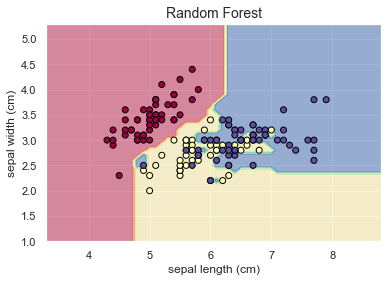

In [56]:
model_RF = RandomForestClassifier(n_estimators=100, random_state=0)

model_RF.fit(X, y)

Z = model_RF.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = 'Spectral', alpha = .5)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = 'Spectral', edgecolors = 'black')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Random Forest', size = 14);

y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)
print('Train score:', accuracy_score(y_train_pred, y_train))
print('Test score:', accuracy_score(y_test_pred, y_test))

### 2.3. Boosting (for decision trees)

__AdaBoost__, short for Adaptive Boosting, is a statistical classification meta-algorithm (Freund & Schapire, 1997), who won the 2003 Gödel Prize for their work. It can be used in conjunction with many other types of learning algorithms to improve performance. The output of the other learning algorithms ('weak learners') is combined into a weighted sum that represents the final output of the boosted classifier. AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers. In some problems it can be less susceptible to the overfitting problem than other learning algorithms. The individual learners can be weak, but as long as the performance of each one is slightly better than random guessing, the final model can be proven to converge to a strong learner.

AdaBoost, with decision trees as the weak learners, is often referred to as the best out-of-the-box classifier. For comparison with random forest, in boosting, we allow many weak classifiers (high bias with low variance) to learn form their mistakes sequentially with the aim that they can correct their high bias problem while maintaining the low-variance property. In bagging, we use many overfitted classifiers (low bias but high variance) and do a bootstrap to reduce the variance.

**EXERCISE 9:** Define a AdaBoost model using `AdaBoostClassifier(WEAK_LEARNER, n_estimators=15, learning_rate=1.0, algorithm='SAMME')`. Use the bagging example as template as everything else is the same. Notice the new accuracy levels obtained.

Train score: 0.925
Test score: 0.9333333333333333


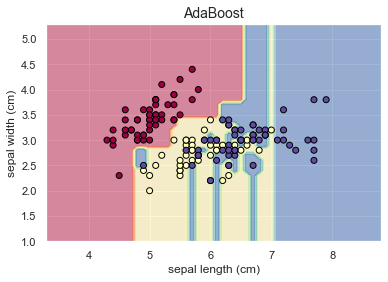

In [64]:
# YOUR CODE HERE



# SOLUTION
weak_learner = DecisionTreeClassifier()
model_Ada = AdaBoostClassifier(weak_learner, n_estimators=15, learning_rate=1., algorithm='SAMME')
model_Ada.fit(X, y)

Z = model_Ada.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = 'Spectral', alpha = .5)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = 'Spectral', edgecolors = 'black')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('AdaBoost', size=14);

y_train_pred = model_Ada.predict(X_train)
y_test_pred = model_Ada.predict(X_test)
print('Train score:', accuracy_score(y_train_pred, y_train))
print('Test score:', accuracy_score(y_test_pred, y_test))

### 2.4. Decision tree ensembles for regression

We so far only considered decision trees within the context of classification, but they can also be made to work in the case of regression (that is, continuous rather than categorical variables). Let us consider Random Forest using `RandomForestRegressor`.

Consider the following data, drawn from the combination of a fast and slow oscillation:

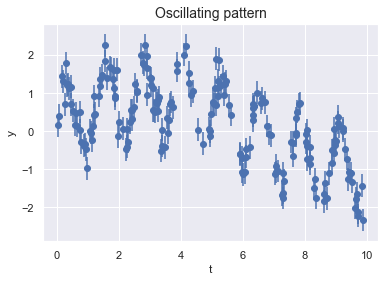

In [67]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def data(x, sigma = .3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = data(x)
plt.errorbar(x, y, .3, fmt='o')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Oscillating pattern', size=14);

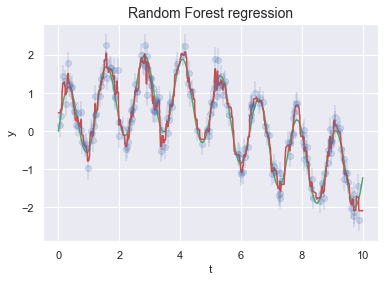

In [68]:
model_RFregr = RandomForestRegressor(200).fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = model_RFregr.predict(xfit[:, None])
ytrue = data(xfit, sigma = 0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.2)
plt.plot(xfit, ytrue, '-g')
plt.plot(xfit, yfit, '-r')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Random Forest regression', size=14);

We see that the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model. We will explore decision tree regression in geoscience in chapter 3d.

## 3. Geoscience application: Tectonic classification of basalts from geochemistry

### 3.1. Problem context

We will reproduce the study of Vermeesch (2006), which is called 'Tectonic discrimination of basalts with classification trees'. The problem consists in the classification of basaltic rocks by tectonic affinity (our labelling) as a function of geochemical variables (our features). Trees here allow the simultaneous use of an unlimited number of geochemical features, while still permitting visualization by an easy-to-use, two-dimensional graph. We will use selected variables from the Vermeesch (2006) data set (Appendix A. Supplementary data) and only reproduce part of the original study. Like in the publication, we will use 10-fold cross-validation to assess the model performance (the study obtained 89% accuracy for a decision tree with post-pruning).

_Vermeesch (2006) training set_: An extensive dataset of 756 samples compiled from the online PETDB and GEOROC databases. Contains:
* 256 __Island arc basalt (IAB)__ samples from the Aeolian, Izu-Bonin, Kermadec, Kurile, Lesser Antilles, Mariana, Scotia, and Tonga arcs
* 241 __Mid-ocean ridge basalt (MORB)__ samples from the East Pacific Rise, Mid Atlantic Ridge, Indian Ocean, and Juan de Fuca Ridge
* 259 __Ocean-island basalt (OIB)__ samples from St. Helena, the Canary, Cape Verde, Caroline, Crozet, Hawaii-Emper- or, Juan Fernandez, Marquesas, Mascarene, Samoan, and Society islands

51 geochemical features were used (in the following order):
* Major element concentrations (in weight percent): SiO$_2$, TiO$_2$, Al$_2$O$_3$, Fe$_2$O$_3$, FeO, CaO, MgO, MnO, K$_2$O, Na$_2$O, and P$_2$O$_5$
* Minor and trace element concentrations (in ppm): La, Ce, Pr, Nd, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu, Sc, V, Cr, Co, Ni, Cu, Zn, Ga, Rb, Sr, Y, Zr, Nb, Sn, Cs, Ba, Hf, Ta, Pb, Th, and U
* Isotopic ratios: $^{143}$Nd/$^{144}$Nd, $^{87}$Sr/$^{86}$Sr, $^{206}$Pb/$^{204}$Pb, $^{207}$Pb/$^{204}$Pb, and $^{208}$Pb/$^{204}$Pb

<img src="figs_notebook/ref_ref_Vermeesch.png" width = 400>

__Imputation of missing values__: None of the 756 samples have all 51 features measured. Vermeesch (2006) indicated that it is not a problem for the construction of the trees as early algorithms dealt with missing values in different ways. It is now common practice to impute missing values, i.e. replacing the `NaN` value by the most frequent occurrence, mean or median. This will be done below via `sklearn.impute.SimpleImputer`.

_Vermeesch (2006) test set_: An independent set of 182 samples.

### 3.2. Data reading

Let us first load the data set.

In [69]:
import pandas as pd
from sklearn.impute import SimpleImputer

data_train = pd.read_csv('data/1-s2.0-S0016703705009701-mmc1.csv', header = None)
data_test = pd.read_csv('data/1-s2.0-S0016703705009701-mmc3.csv', header = None)

X_train = data_train.loc[:, data_train.columns != 0]
y_train = data_train[0]
X_test = data_test.loc[:, data_test.columns != 0]
y_test = data_test[0]

# Imputation of missing values
imp = SimpleImputer(strategy = "most_frequent")  # then apply imp.fit_transform() - see below

data_train

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,MORB,48.200,2.520,15.20,2.31,8.56,9.69,7.150,0.170,0.900,...,5.20,NaN,2.150,1.4881,0.4941,NaN,0.703000,NaN,NaN,NaN
1,MORB,49.580,1.165,17.82,9.31,NaN,11.87,7.130,0.155,0.070,...,1.98,0.128,0.386,0.1170,0.0350,0.513152,0.702496,18.439,15.489,37.878
2,MORB,49.890,1.670,16.16,10.74,NaN,11.05,6.960,0.180,0.190,...,3.13,0.216,0.638,0.2240,0.1000,0.513134,0.702518,18.504,15.494,37.920
3,MORB,50.170,1.565,16.58,9.92,NaN,11.40,7.120,0.165,0.265,...,2.95,0.205,0.535,0.2010,0.2710,0.513155,0.702505,18.426,15.466,37.828
4,MORB,50.325,1.630,15.46,10.71,NaN,10.79,7.655,0.180,0.130,...,2.91,0.202,0.604,0.2160,0.0700,0.513147,0.702517,18.438,15.487,37.865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,IAB,50.970,0.780,18.86,NaN,NaN,10.85,4.710,0.160,0.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.820,15.556,38.389
752,IAB,51.000,1.410,17.06,3.80,7.04,9.97,4.960,0.170,0.730,...,NaN,NaN,NaN,NaN,NaN,NaN,0.703480,NaN,NaN,NaN
753,IAB,52.560,1.210,17.74,2.28,7.53,10.48,5.570,0.240,0.290,...,NaN,NaN,NaN,NaN,NaN,NaN,0.703620,NaN,NaN,NaN
754,IAB,52.590,1.500,16.88,2.41,7.90,10.83,4.910,0.260,0.540,...,NaN,NaN,NaN,NaN,NaN,NaN,0.703630,NaN,NaN,NaN


### 3.3. Decision tree modelling

**EXERCISE 10:** Define a feature subset `X_train_subset` that only includes the elements Si, Ti and Sr (i.e. Silicon, Titanium, and Strontium) only (read the HEADER file for details about the data format). Then make a simple decision tree of depth 2 and plot the resulting tree for easy investigation. _Hint: if you get the following error message: `ValueError: Input contains NaN...`, recall to impute missing data first as explained above_

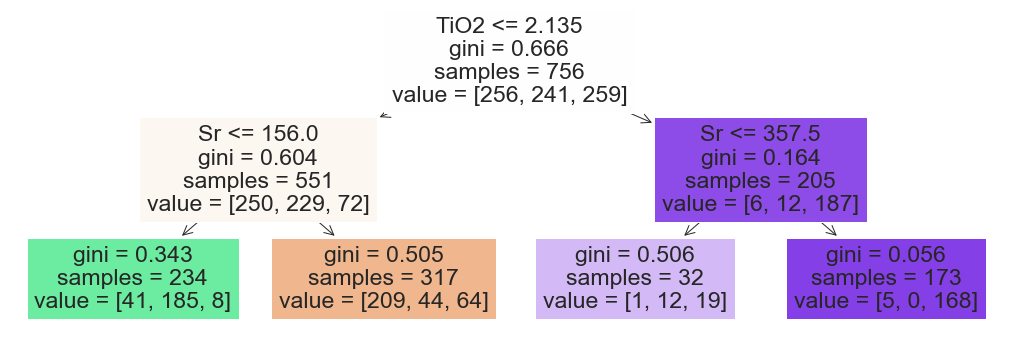

In [90]:
# YOUR CODE HERE



# SOLUTION
#Ti–Zr–Sr
X_train_subset = X_train.loc[:, [1,2,35]]

# DECISION TREE MODEL (to illustrate how decisions are made)
model_tree = DecisionTreeClassifier(max_depth = 2).fit(imp.fit_transform(X_train_subset), y_train)

# PLOT
plt.figure(figsize = (18,6))
plot_tree(model_tree, feature_names = ['SiO2','TiO2','Sr'], filled = True);

**EXERCISE 11:** Using all the available variables, generate a decision tree classifier (based on the method of your choice while limiting overfitting: pruning, bagging, Random Forest or boosting) and use 10-fold cross-validation to explore the best hyperparameter configuration.

In [92]:
# YOUR CODE HERE



# SOLUTION
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

X_train_corr = imp.fit_transform(X_train)

weak_learner = DecisionTreeClassifier()
my_model = AdaBoostClassifier(weak_learner, n_estimators=15, learning_rate=1., algorithm='SAMME')
my_model.fit(X_train_corr, y_train)

cross_val_score(my_model, X_train_corr, y_train, cv = 10)

array([0.89473684, 0.92105263, 0.86842105, 0.81578947, 0.88157895,
       0.82894737, 0.89333333, 0.86666667, 0.92      , 0.73333333])

**EXERCISE 12:** Test the performance of your final model on the test set. What accuracy do you obtain? Did you do better or worse than Vermeesch (2006)? Was his 89% accuracy obtained on the test set or training set? Check the article for the answer. Generate a confusion matrix and compare again with Vermeesch (2006).

In [94]:
# YOUR CODE HERE



# SOLUTIONX_test_corr = imp.fit_transform(X_test)
y_test_pred = my_model.predict(X_test_corr)
print('Test score:', accuracy_score(y_test_pred, y_test))

print('Test score for full tree from Vermeesch (2006):', (54+49+56)/182)   #corrected

print(confusion_matrix(y_test, my_model.predict(X_test_corr)))

Test score: 0.8131868131868132
Test score for full tree from Vermeesch (2006): 0.7747252747252747
[[41 14 12]
 [ 6 49  0]
 [ 1  1 58]]


_YOUR ANSWER HERE_

SOLUTION

"successful classification is 89% for the first and 84% for the second tree, as determined by 10-fold cross-validation" - so not on test set, so we obtain similar results.

## 4. References

* Breiman (1996), Bagging Predictors, Machine Learning, 24(2), 123-140
* Breiman (2001), "Random Forests", Machine Learning, 45 (1), 5–32
* Fisher (1936), The use of multiple measurements in taxonomic problems, Annals of Human Genetics, 7 (2), 179-188
* Freund & Schapire (1997), A decision-theoretic generalization of on-line learning and an application to boosting
* Ho (1995), Random decision forests, Proc. 3rd Int. Conf. Document Analysis and Recognition, 278-282
* UCI Machine Learning Repository: [Iris Data Set](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)
* Vermeesch (2006), Tectonic discrimination of basalts with classification trees, Geochimica et Cosmochimica Acta, 70, 1839–1848, doi:10.1016/j.gca.2005.12.016 (includes dataset in: Appendix A. Supplementary data)